In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import normalize
from scipy import interp
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
sys.path.append('/home/lolo/Desktop/dnnComm/vde/vde/')
from vde import VDE 



name= '/home/lolo/Desktop/dnnComm/RML2016.10a_dict.pkl'
data = pd.read_pickle(name)

In [2]:
list = []
for d in data:
    list.append(d)    

In [8]:
# what is the best normalization strategy?
# time-lag is considered in features, data augmentation and cost funstion.
lag_time = 8
trajs = []
stride = 1
for l in range(len(list)):
    d = data[list[l]]
    for i in range(0, len(d), stride):
        dd = normalize(d[i, :, :], axis=1, norm='l2').T
        #dd = normalize(dd[i, : :], axis=0, norm='l2')
        #dd = d[i, :, :].T
        Dt = dd.shape
        dddd = dd
        for t in range(1, lag_time):
            ddd = np.zeros(Dt)
            ddd[:-t] = dd[:-t] - dd[t:] # lag-differences as features
            dddd = np.append(dddd, ddd, axis=1)
        trajs.append(dddd)
print ('samples,features', trajs[0].shape)    
print ('#data', len(trajs))

samples,features (128, 16)
#data 220000


In [9]:
mdl = VDE(trajs[0].shape[-1], lag_time=lag_time,
          hidden_size=256, hidden_layer_depth=3,
          batch_size=100, n_epochs=1, cuda=False, 
          sliding_window=False, dropout_rate=0.3,
          learning_rate=1E-3, autocorr=True)

In [10]:
# for some reasons autocorr_loss does behave properly!
mdl.fit(trajs)

Epoch: 0
Batch 100, loss = 1.1849
rec_loss = 0.2184, autocorr_loss = 0.9665
Batch 200, loss = 1.0120
rec_loss = 0.1193, autocorr_loss = 0.8926
Batch 300, loss = 0.9457
rec_loss = 0.0752, autocorr_loss = 0.8705
Batch 400, loss = 1.0052
rec_loss = 0.0598, autocorr_loss = 0.9454
Batch 500, loss = 0.9571
rec_loss = 0.0373, autocorr_loss = 0.9197
Batch 600, loss = 0.8355
rec_loss = 0.0312, autocorr_loss = 0.8043
Batch 700, loss = 0.6433
rec_loss = 0.0287, autocorr_loss = 0.6146
Batch 800, loss = 0.8397
rec_loss = 0.0237, autocorr_loss = 0.8161
Batch 900, loss = 0.6642
rec_loss = 0.0198, autocorr_loss = 0.6445
Batch 1000, loss = 0.8299
rec_loss = 0.0215, autocorr_loss = 0.8084
Batch 1100, loss = 0.6964
rec_loss = 0.0201, autocorr_loss = 0.6763
Batch 1200, loss = 0.5912
rec_loss = 0.0204, autocorr_loss = 0.5708
Batch 1300, loss = 0.6319
rec_loss = 0.0151, autocorr_loss = 0.6169
Batch 1400, loss = 0.6098
rec_loss = 0.0165, autocorr_loss = 0.5932
Batch 1500, loss = 0.5334
rec_loss = 0.0171, aut

In [11]:
delta = np.int(data[list[0]].shape[0]/stride)

def scatter(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    w -= w.min()
    w /= w.max()
    ax.scatter(*np.vstack(trajs[l*delta:(l+1)*delta])[::stride, 0:2].T, c=cmap(w), s=2)

    return ax

def hist(decomposition, cmap='plasma', stride=1, l=0, ax=None):

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    cmap = plt.get_cmap(cmap)
    w = np.concatenate(decomposition.transform(trajs[l*delta:(l+1)*delta]))[::stride].ravel()
    ax.hist(w, bins=100)

    return ax
def clean_up(ax):
    ax.axis('off')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

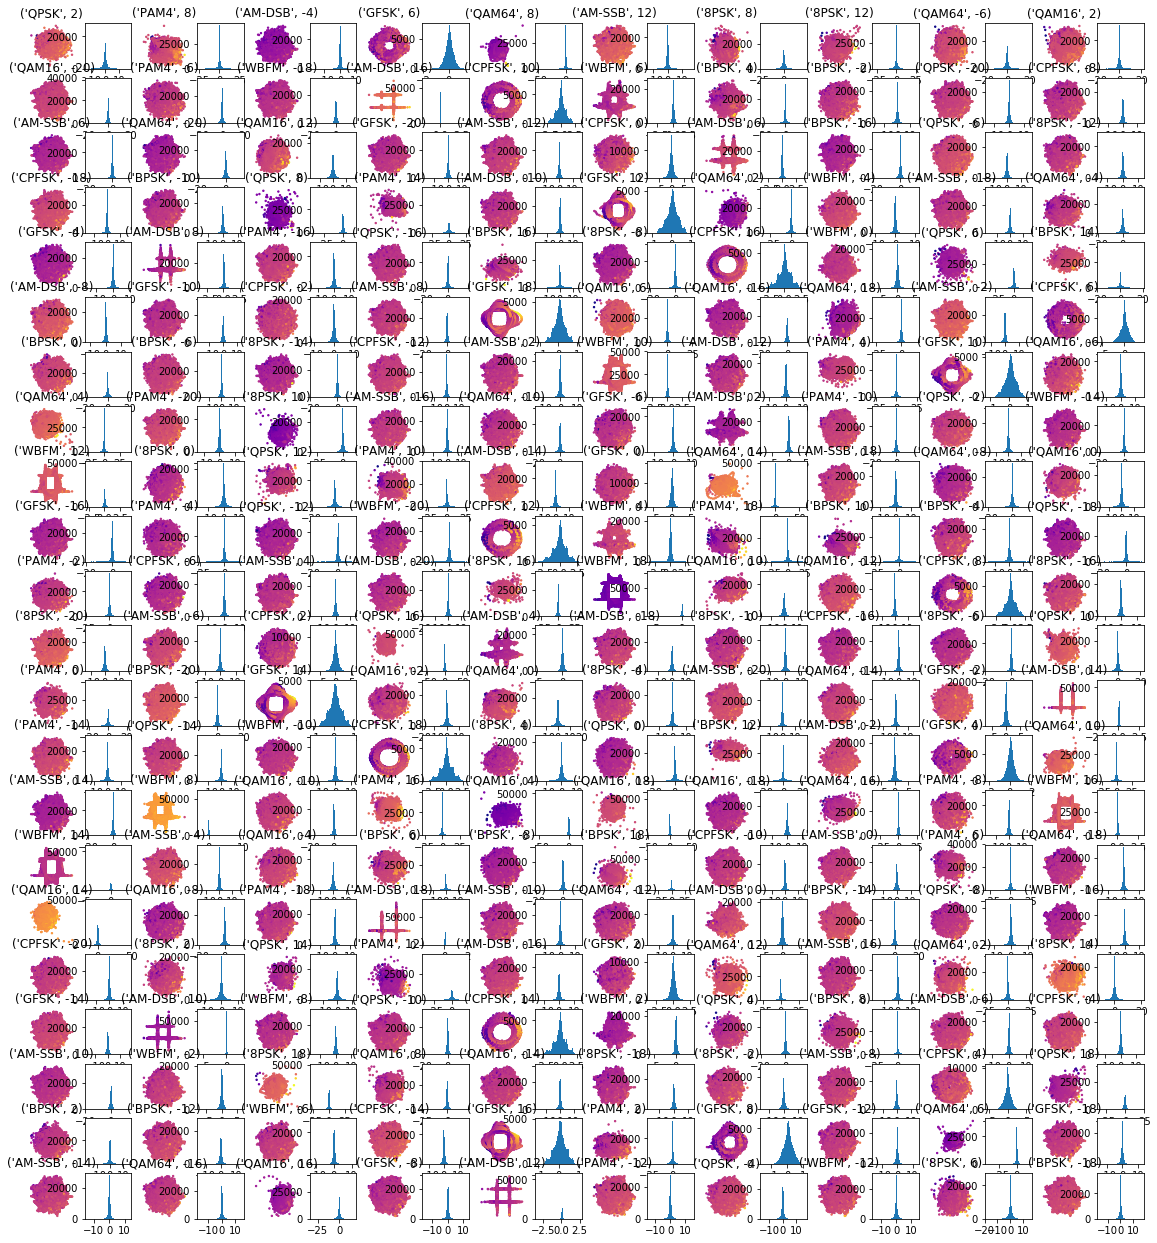

In [13]:
fig = plt.figure(figsize=(2*10, 1*22))
c = 0
for i in range(22):
    for j in range(10):
        ax1 = fig.add_subplot(1*22, 2*10, i*2*10+2*j+1)
        ax2 = fig.add_subplot(1*22, 2*10, i*2*10+2*j+2)
        scatter(mdl, cmap='plasma_r', l=c, ax=ax1)
        ax1.set_title(list[c]); clean_up(ax1)
        hist(mdl, cmap='plasma_r', l=c, ax=ax2)
        #ax2.set_title('Signature')
        c += 1
#plt.savefig('result.png')
#plt.close(fig)